## Loading Packages

In [1]:
import warnings

from skimage.graph import route_through_array
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests as rq
import xarray as xr
import getpass

%matplotlib inline
warnings.simplefilter("ignore")

## Instantiate connection

In [2]:
'''store, in python variables, values of USERNAME and PASSWORD 
(or request them from free) as well as the DATASET_ID.'''

USERNAME = 'username'
PASSWORD = getpass.getpass('Enter your password: ')
DATASET_ID = 'global-analysis-forecast-wav-001-027'

Enter your password: ········


In [3]:
'''instantiate the connection to the OPeNDAP server thanks to a local 
function copernicusmarine_datastore(): '''

#! /usr/bin/env python3
# -*- coding: utf-8 -*-
__author__ = "Copernicus Marine User Support Team"
__copyright__ = "(C) 2021 E.U. Copernicus Marine Service Information"
__credits__ = ["E.U. Copernicus Marine Service Information"]
__license__ = "MIT License - You must cite this source"
__version__ = "202104"
__maintainer__ = "D. Bazin, E. DiMedio, C. Giordan"
__email__ = "servicedesk dot cmems at mercator hyphen ocean dot eu"

def copernicusmarine_datastore(dataset, username, password):
    from pydap.client import open_url
    from pydap.cas.get_cookies import setup_session
    cas_url = 'https://cmems-cas.cls.fr/cas/login'
    session = setup_session(cas_url, username, password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    database = ['my', 'nrt']
    url = f'https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}'
    try:
        data_store = xr.backends.PydapDataStore(open_url(url, session=session))
    except:
        url = f'https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}'
        data_store = xr.backends.PydapDataStore(open_url(url, session=session))
    return data_store


In [4]:
data_store = copernicusmarine_datastore(DATASET_ID, USERNAME, PASSWORD)

In [5]:
dataset = xr.open_dataset(data_store)
dataset.head()

<xarray.Dataset>
Dimensions:    (longitude: 5, latitude: 5, time: 5)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 -179.8 -179.7
  * latitude   (latitude) float64 -80.0 -79.92 -79.83 -79.75 -79.67
  * time       (time) datetime64[ns] 2019-01-01T03:00:00 ... 2019-01-01T15:00:00
Data variables: (12/17)
    VHM0       (time, latitude, longitude) float32 ...
    VMDR_WW    (time, latitude, longitude) float32 ...
    VHM0_WW    (time, latitude, longitude) float32 ...
    VMDR_SW1   (time, latitude, longitude) float32 ...
    VTM01_SW1  (time, latitude, longitude) float32 ...
    VMDR_SW2   (time, latitude, longitude) float32 ...
    ...         ...
    VTPK       (time, latitude, longitude) float32 ...
    VSDX       (time, latitude, longitude) float32 ...
    VSDY       (time, latitude, longitude) float32 ...
    VPED       (time, latitude, longitude) float32 ...
    VTM02      (time, latitude, longitude) float32 ...
    VTM01_WW   (time, latitude, longitude) float32 ...
Attributes: (12/27)
    Conventions:                   CF-1.6
    time_coverage_start:           20220116-03:00:00
    time_coverage_end:             20220117-00:00:00
    date_created:                  20220107-07:35:00
    product_type:                  forecast
    product:                       GLOBAL_ANALYSIS_FORECAST_WAV_001_027
    ...                            ...
    geospatial_lon_step:           0.08332825
    geospatial_lon_units:          degree
    geospatial_lat_min:            -80.0
    geospatial_lat_max:            90.0
    geospatial_lat_step:           0.08333588
    geospatial_lat_units:          degree

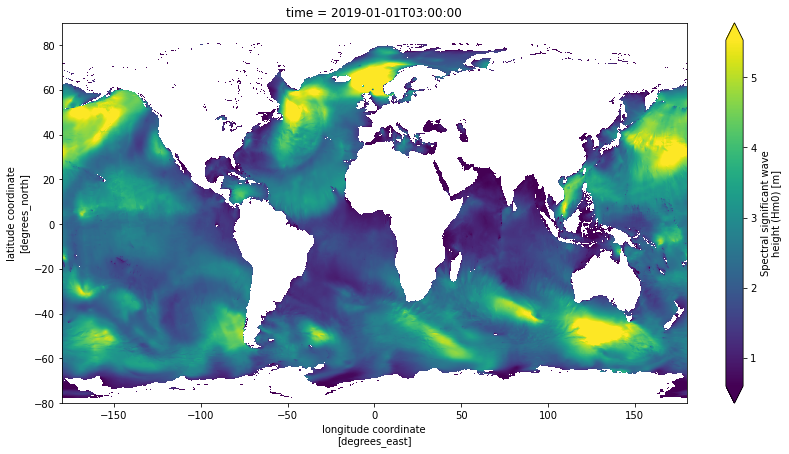

In [6]:
# Plot one variable in the dataset for a specific time slice
dataset.VHM0.isel(time=0).plot(robust=True, aspect=2, size=7);

In [7]:
# Set bounding box for the allowed routing corridor
bbox = ((-80, 32),(-5, 47))
# Select time
time_slice = 0

In [8]:
# Get array index to the value that is closest to a given value
def get_closest(array, value):
    return np.abs(array - value).argmin()

In [9]:
# Get indices of the bbox
lon_min = get_closest(dataset.longitude.data, bbox[0][0])
lat_min = get_closest(dataset.latitude.data, bbox[0][1])
lon_max = get_closest(dataset.longitude.data, bbox[1][0])
lat_max = get_closest(dataset.latitude.data, bbox[1][1])

In [10]:
from skimage.graph import route_through_array
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os

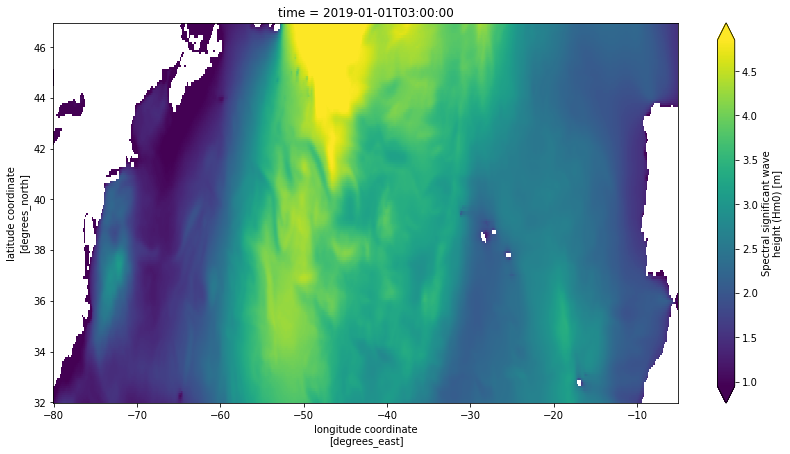

In [11]:
# Extract array from dataset to define the cost in the routing algorithm 
# -> subset space, time and variable
wave_height = dataset.VHM0.isel(time=time_slice, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))
wave_height.plot(robust=True, aspect=2, size=7);

In [36]:
costs = wave_height.data
# Set NaN values to large costs as the algorithm cannot handle NaNs
costs[np.isnan(costs)] = 2 * np.nanmax(costs) 
np.shape(costs)

(180, 900)